### Quantifying Model Fit

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols 

##### The Coefficient of Determination 

R-squared ('r' for single and 'R' for multiple explanatory variables) is the proportion of variance in the response variable that is predictable from the explanatory variable. The range is [0,1]; 1 for perfect fit 0 for worst possible fit.

In simpler terms, the coefficient of determination is simply the correlation between the explanatory and the response variable squared.

##### Residual Standard Error (RSE)

RSE is the 'typical' residual value of observed and predicted datapoints. It can also be viewed as the standard deviation of the residuals in a linear regression model. Since it is an SD, it has the same unit as the response variable. Als note that Mean Squared Error (MSE) is equal to the square of the RSE. MSE = RSE^2. 

In [53]:
# Going back to the fish dataset

fish = pd.read_csv('Data/fish.csv')
fish.head()

,species,mass_g,length_cm
0,Bream,242.0,23.2
1,Bream,290.0,24.0
2,Bream,340.0,23.9
3,Bream,363.0,26.3
4,Bream,430.0,26.5


In [54]:
bream = fish[fish['species'] == 'Bream']

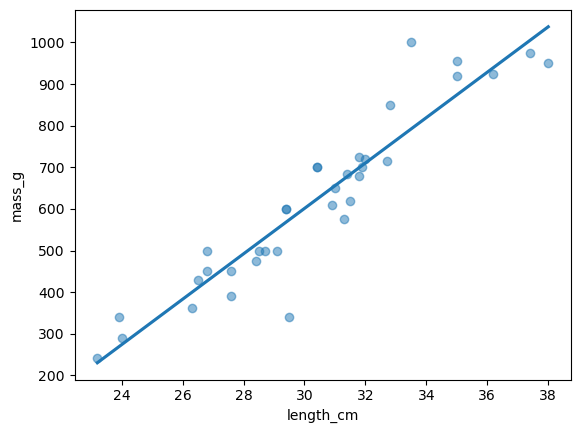

In [55]:
sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None,
    scatter_kws={'alpha':0.5}
)

plt.show()

In [56]:
# Creating the model 
mdl_bream_length_vs_mass = ols('mass_g ~ length_cm', data=bream).fit()

mdl_bream_length_vs_mass.rsquared

0.8780627095147174

As shown above, an r^2 of 0.88 indicates that the model explains about 88% of the variability in the mass of breams.

In [57]:
# Calculating RSS
resid_diffs = mdl_bream_length_vs_mass.resid ** 2
rss = resid_diffs.sum()
rss

181452.31780412616

In [58]:
# Calculating RSE
rss_div_dof = rss / (resid_diffs.shape[0] - 2)
rse = round(np.sqrt(rss_div_dof), 2)
rse


74.15

This RSE value suggests that the typical difference between the observed masses and predicted masses is about 74.15.

In [59]:
# Getting MSE from RSE
mse = rse ** 2
round(mse, 2)
# Note that there is a straightforward way of getting MSE 
#using .mse_resid attribute

5498.22

In [60]:
exp_data = pd.DataFrame({'length_cm':np.arange(28, 36, 2)})

bream_predict = exp_data.assign(
    predicted_mass_g=mdl_bream_length_vs_mass.predict(exp_data)
)

bream_predict

,length_cm,predicted_mass_g
0,28,492.051901
1,30,601.151863
2,32,710.251825
3,34,819.351787


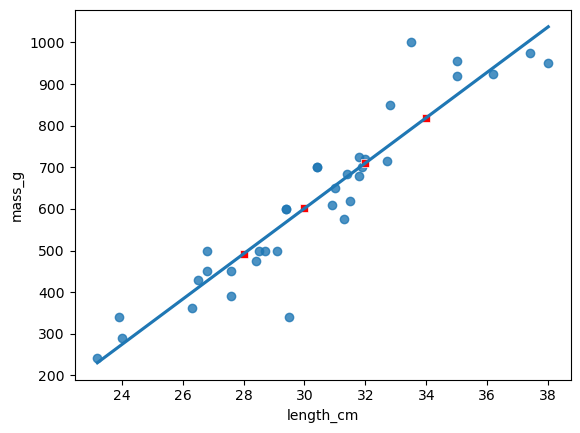

In [61]:
fig = plt.figure()

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None
)

sns.scatterplot(
    x='length_cm',
    y='predicted_mass_g',
    data=bream_predict,
    color='r',
    marker='s'
)

plt.show()

### Visualizing Model Fit and Characteristics of Good-Fitting Model

A good-fit model is said to have:
- normally distributed residuals; and
- a residual mean equal to zero

Observe the difference between the two plots below.

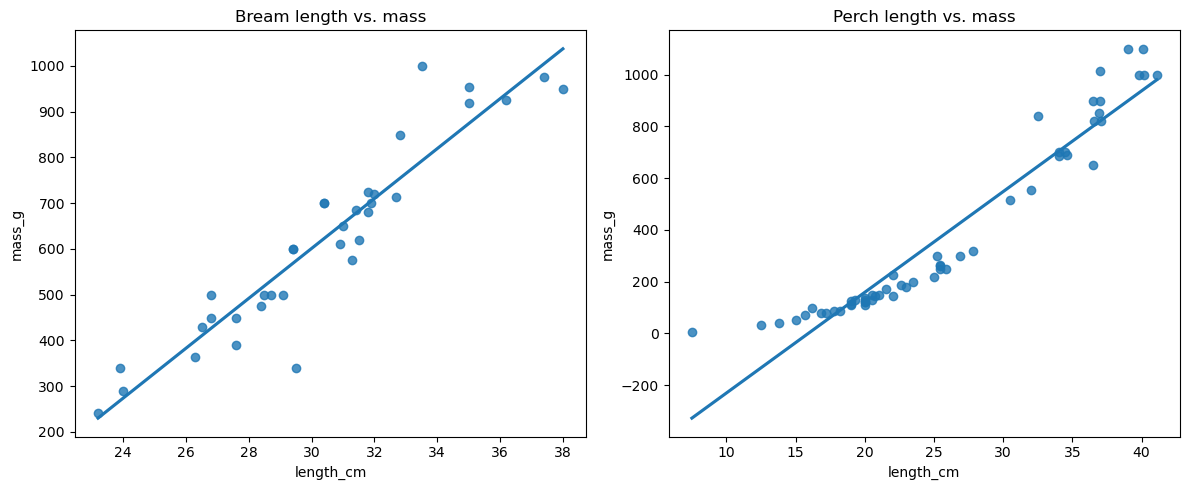

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=bream,
    ci=None,
    ax=ax[0]
)

ax[0].set_title('Bream length vs. mass')

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=fish[fish['species'] == 'Perch'],
    ci=None,
    ax=ax[1]
)

ax[1].set_title('Perch length vs. mass')

plt.tight_layout()
plt.show()